# PDG ATTACK #

### *Import*

In [ ]:
# LIBRERIE UTILI
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
from matplotlib import pyplot as plt
import art

if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

print("GPU Available: ", tf.test.is_gpu_available())

In [1]:
import numpy as np
import torch
from torch.nn import CrossEntropyLoss
from PIL import Image
from torchvision import transforms
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier
import matplotlib.pyplot as plt
import tensorflow as tf

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\cassd\miniconda3\envs\ai4cyber\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


### initialization


In [2]:
if str(device) in 'cuda':
    print("Import Inception.Inception")
    import inception
    resnet = inception.InceptionResnetV1(pretrained='vggface2').eval()
elif str(device) == "cpu":
    print("Import Facenet.Inception")
    from facenet_pytorch import InceptionResnetV1
    resnet = InceptionResnetV1(pretrained='vggface2').eval()

Import Inception.Inception


In [3]:
from utils import get_labels


resnet.classify = True
resnet.to(device)
LABELS = get_labels()

In [4]:

from torch.nn import CrossEntropyLoss
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescentPyTorch


#Impostare l'input shape
model = PyTorchClassifier(resnet,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device) #This class implements a classifier with the PyTorch framework.


### Untargeted Attack on all test set

In [5]:
# PGD generic Attack for all samples
import os
import re
from utils import load_image_NN1

dataset_dir = "test_set_cropped_piccolo/" 
eps_step = [2e-05, 5e-05, 7e-05, 2e-03, 5e-03, 7e-03, 2e-02, 5e-02, 7e-02, 1e-01] #La dimensione del passo della variazione dell'input a ogni iterazione. Questo parametro definisce quanto grande sarà ogni passo nella direzione del gradiente. #La dimensione del passo della variazione dell'input per il calcolo della perturbazione minima. Questo parametro è utilizzato quando minimal è impostato su True.
max_iter = [2,5,7]  # Il numero massimo di iterazioni. Questo parametro determina quante volte l'attacco iterativo sarà eseguito.
 
eps_range = 0.1 #Questo valore determina l'ampiezza massima della perturbazione aggiunta agli input originali. Può essere un valore singolo (int o float) o un array numpy (ndarray).

accuracy_for_eps = []
accuracy_for_max_iter = []
perturbation_for_eps = []
perturbation_for_max_iter = []
correct_predictions = 0
total_images = 0
print("Inizio Attacco PGD NON-TARGETED")
for i in range(len(max_iter)):
        print("**** Attacco con max_iter {} **** ".format(max_iter[i]))
        for step in eps_step:   #Se qualcosa funziona strano controllare questo zip
            correct_predictions = 0
            total_images = 0
            perturbation = []
            
            attack = ProjectedGradientDescentPyTorch(estimator=model, eps = eps_range, eps_step=step, targeted=False, max_iter = max_iter[i])
            
            print("**** Attacco con eps:{} con step a {} ****".format(eps_range,step))
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image_NN1(person_path)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img)
                    model_predictions = model.predict(test_images_adv)
                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                    print("Etichetta corretta:", correct_label)   
                    perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  #Salvo le perturbazioni applicate su ogni immagine
                    predicted_label = LABELS[np.array(model_predictions[0].argmax())]
                    print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    total_images+=1
                    
                    predicted_label = str(predicted_label)

                    if correct_label in predicted_label:
                        correct_predictions+=1

                    accuracy = correct_predictions/total_images
                    print("Adversarial Sample misclassificati correttamente attuale: {}%".format((100-(accuracy*100))))
            

            if total_images != 0:    #Per ogni epsilon impostata salvo in accuracy plot
                if len(perturbation) == total_images:
                    perturbazione_media = sum(perturbation)/total_images    #Calcolo la media delle perturbazioni applicate su tutte le immagini per una determinata epsilon
                    perturbation_for_eps.append(perturbazione_media)
                    print("----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: {} equivale a {}% ----------------".format(step,perturbazione_media))

                final_accuracy = correct_predictions/total_images
                accuracy_for_eps.append(final_accuracy)
                print("----------- Accuracy sugli adversarial Sample per eps_step: {} equivale a {}% ----------------".format(step,final_accuracy))
                print("")
            #Per ogni epsilon impostata salvo in accuracy plot
        if True:#len(perturbation_for_eps) == len(eps_range):
            perturbazione_media_per_max_iter = sum(perturbation_for_eps)/len(eps_step) # Calcolo la perturbazione media dopo aver provato tutte le epsilon,quindi la media delle perturbazioni per eps_range
            perturbation_for_max_iter.append(perturbazione_media_per_max_iter)
            print("----------- Perturbazione media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],perturbation_for_max_iter[i]))
            perturbation_for_eps = []
        if True:#len(accuracy_for_eps) == len(eps_range):
            accuracy_media_per_max_iter = sum(accuracy_for_eps)/len(eps_step) # Calcolo l'accuracy media dopo aver provato tutte le epsilon,quindi la media dell'accuracy per ogni eps_range
            accuracy_for_max_iter.append(accuracy_media_per_max_iter)
            print("----------- Accuracy media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_for_max_iter[i]))
            accuracy_for_eps = []
        print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")
        print()
# correct_predictions = 0
# total_images = 0
# for filename in os.listdir(dataset_dir):
#     if filename.endswith(".jpg") or filename.endswith(".jpeg"):
#         person_path = os.path.join(dataset_dir, filename)
#         print("Immagine:", filename)
#         test_img = load_image(person_path)
#         test_img = test_img.unsqueeze(0)
#         test_img = test_img.numpy()
#         test_images_adv = attack.generate(test_img)
#         model_predictions = model.predict(test_images_adv)
#         correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
#         print("Etichetta corretta:", correct_label)   
#         perturbation = np.mean(np.abs((test_images_adv - test_img)))
#         predicted_label = LABELS[np.array(model_predictions[0].argmax())]
#         print("Predetto {} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))
#         total_images+=1

#         if predicted_label == correct_label:
#             correct_predictions+=1

#         accuracy = correct_predictions/total_images
#         print("Accuracy sugli adversarial Sample: {}%".format((100-(accuracy*100))))
        

# if total_images != 0:
#     final_accuracy = correct_predictions/total_images
#     print("----------- Accuracy FINALE sugli adversarial Sample: {}\% ----------------".format(final_accuracy))

Inizio Attacco PGD NON-TARGETED
**** Attacco con max_iter 2 **** 
**** Attacco con eps:0.1 con step a 2e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.693822860717773 e con perturbazione 3.8263726310105994e-05
Adversarial Sample misclassificati correttamente attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.453540802001953 e con perturbazione 3.811205897363834e-05
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 11.097878456115723 e con perturbazione 3.790897608269006e-05
Adversarial Sample misclassificati correttamente attuale: 33.33333333333334%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.835945129394531 e con perturbazione 3.821367135969922e-05
Adversarial Sample misclassificati correttamente attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.290242195129395 e con perturbazione 3.811870192294009e-05
Adversarial Sample misclassificati correttamente attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.163195610046387 e con perturbazione 3.812631985056214e-05
Adversarial Sample misclassificati correttamente attuale: 16.666666666666657%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.714770317077637 e con perturbazione 3.805775486398488e-05
Adversarial Sample misclassificati correttamente attuale: 14.285714285714292%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 12.02921199798584 e con perturbazione 3.7912097468506545e-05
Adversarial Sample misclassificati correttamente attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.899056434631348 e con perturbazione 3.813600051216781e-05
Adversarial Sample misclassificati correttamente attuale: 11.111111111111114%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.5523681640625 e con perturbazione 3.773808930418454e-05
Adversarial Sample misclassificati correttamente attuale: 10.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 2e-05 equivale a 3.805873966484796e-05% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 2e-05 equivale a 0.9% ----------------
**** Attacco con eps:0.1 con step a 5e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.646801948547363 e con perturbazione 9.487125498708338e-05
Adversarial Sample misclassificati correttamente attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Jürgen_Trittin con probabilità 10.434152603149414 e con perturbazione 9.420992864761502e-05
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.987588882446289 e con perturbazione 9.376038360642269e-05
Adversarial Sample misclassificati correttamente attuale: 33.33333333333334%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.744102478027344 e con perturbazione 9.473095997236669e-05
Adversarial Sample misclassificati correttamente attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.239717483520508 e con perturbazione 9.461909212404862e-05
Adversarial Sample misclassificati correttamente attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.098052024841309 e con perturbazione 9.41934558795765e-05
Adversarial Sample misclassificati correttamente attuale: 16.666666666666657%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.65614128112793 e con perturbazione 9.432013757759705e-05
Adversarial Sample misclassificati correttamente attuale: 14.285714285714292%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.962738990783691 e con perturbazione 9.41342514124699e-05
Adversarial Sample misclassificati correttamente attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.828563690185547 e con perturbazione 9.468427742831409e-05
Adversarial Sample misclassificati correttamente attuale: 11.111111111111114%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.415960311889648 e con perturbazione 9.064077312359586e-05
Adversarial Sample misclassificati correttamente attuale: 10.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 5e-05 equivale a 9.401645147590897e-05% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 5e-05 equivale a 0.9% ----------------
**** Attacco con eps:0.1 con step a 7e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.615327835083008 e con perturbazione 0.00013242918066680431
Adversarial Sample misclassificati correttamente attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Jürgen_Trittin con probabilità 10.427314758300781 e con perturbazione 0.00013141291856300086
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.912879943847656 e con perturbazione 0.00013046820822637528
Adversarial Sample misclassificati correttamente attuale: 33.33333333333334%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.682324409484863 e con perturbazione 0.00013204205606598407
Adversarial Sample misclassificati correttamente attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.206011772155762 e con perturbazione 0.0001312850508838892
Adversarial Sample misclassificati correttamente attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.054800033569336 e con perturbazione 0.00013109722931403667
Adversarial Sample misclassificati correttamente attuale: 16.666666666666657%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.617053985595703 e con perturbazione 0.00013153566396795213
Adversarial Sample misclassificati correttamente attuale: 14.285714285714292%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.918374061584473 e con perturbazione 0.00013098104682285339
Adversarial Sample misclassificati correttamente attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.781578063964844 e con perturbazione 0.00013174790365155786
Adversarial Sample misclassificati correttamente attuale: 11.111111111111114%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.330840110778809 e con perturbazione 0.0001255602401215583
Adversarial Sample misclassificati correttamente attuale: 10.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 7e-05 equivale a 0.0001308559498284012% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 7e-05 equivale a 0.9% ----------------
**** Attacco con eps:0.1 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 9.613410949707031 e con perturbazione 0.0033232704736292362
Adversarial Sample misclassificati correttamente attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Bobby_Jindal con probabilità 9.681119918823242 e con perturbazione 0.0032124214340001345
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Noelle_Reno con probabilità 10.465868949890137 e con perturbazione 0.003018886549398303
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


Etichetta corretta: Ashley_Scott
Predetto  Cerys_Matthews con probabilità 10.241692543029785 e con perturbazione 0.003251902060583234
Adversarial Sample misclassificati correttamente attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 9.985503196716309 e con perturbazione 0.0032680975273251534
Adversarial Sample misclassificati correttamente attuale: 60.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 9.036730766296387 e con perturbazione 0.0031852461397647858
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 9.712828636169434 e con perturbazione 0.0032182701397687197
Adversarial Sample misclassificati correttamente attuale: 42.85714285714286%


Etichetta corretta: Christopher_Nolan
Predetto  Franck_Dubosc con probabilità 9.764442443847656 e con perturbazione 0.003177858656272292
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Anthony_Ogogo con probabilità 11.15236759185791 e con perturbazione 0.003261229023337364
Adversarial Sample misclassificati correttamente attuale: 55.55555555555556%


Etichetta corretta: Diego_Maradona
Predetto  Tony_Leung_Chiu_Wai con probabilità 11.189728736877441 e con perturbazione 0.002949465997517109
Adversarial Sample misclassificati correttamente attuale: 60.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.003186664800159633% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.4% ----------------
**** Attacco con eps:0.1 con step a 0.005 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Greg_Kinnear con probabilità 9.728375434875488 e con perturbazione 0.007331763859838247
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Bobby_Jindal con probabilità 9.794346809387207 e con perturbazione 0.00683332746848464
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Tanya_Tucker con probabilità 10.629838943481445 e con perturbazione 0.006459630094468594
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lisa_Ann_Walter con probabilità 9.850259780883789 e con perturbazione 0.007131244521588087
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Vladimir_Petković con probabilità 9.122099876403809 e con perturbazione 0.007050253450870514
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Roberto_Vecchioni con probabilità 9.370201110839844 e con perturbazione 0.00696509750559926
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Branch_Warren con probabilità 10.584240913391113 e con perturbazione 0.0069677019491791725
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Sandy_Koufax con probabilità 8.836536407470703 e con perturbazione 0.0068249949254095554
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  J_Alvarez con probabilità 10.242766380310059 e con perturbazione 0.007012233603745699
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Choi_Siwon con probabilità 10.881918907165527 e con perturbazione 0.0066312444396317005
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.005 equivale a 0.006920749181881547% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.005 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.007 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Greg_Kinnear con probabilità 10.09253215789795 e con perturbazione 0.009603683836758137
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Bobby_Jindal con probabilità 9.681074142456055 e con perturbazione 0.008957837708294392
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Tanya_Tucker con probabilità 10.06875991821289 e con perturbazione 0.00840512290596962
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lisa_Ann_Walter con probabilità 9.710949897766113 e con perturbazione 0.009351770393550396
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Vladimir_Petković con probabilità 9.312800407409668 e con perturbazione 0.009032760746777058
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Roberto_Vecchioni con probabilità 9.789621353149414 e con perturbazione 0.00918313954025507
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Branch_Warren con probabilità 10.581448554992676 e con perturbazione 0.00894488301128149
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Sandy_Koufax con probabilità 8.951900482177734 e con perturbazione 0.008850086480379105
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  J_Alvarez con probabilità 9.757888793945312 e con perturbazione 0.009242391213774681
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Choi_Siwon con probabilità 11.181736946105957 e con perturbazione 0.008697331883013248
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.007 equivale a 0.00902690077200532% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.007 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.02 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Greg_Kinnear con probabilità 9.170583724975586 e con perturbazione 0.022358331829309464
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 9.224959373474121 e con perturbazione 0.020711449906229973
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Patrick_Juvet con probabilità 11.637910842895508 e con perturbazione 0.019955720752477646
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lynda_Bellingham con probabilità 12.117756843566895 e con perturbazione 0.02132967859506607
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Eddy_Mitchell con probabilità 9.586430549621582 e con perturbazione 0.021774988621473312
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Ronnie_Wood con probabilità 9.443238258361816 e con perturbazione 0.021790100261569023
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Branch_Warren con probabilità 9.529623031616211 e con perturbazione 0.020288018509745598
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Deniz_Baykal con probabilità 8.379924774169922 e con perturbazione 0.021097395569086075
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Clemente_Mastella con probabilità 12.037210464477539 e con perturbazione 0.021737493574619293
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Ryohei_Chiba con probabilità 11.474294662475586 e con perturbazione 0.020473957061767578
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.02 equivale a 0.021151713468134402% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.02 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Louie_Anderson con probabilità 9.537599563598633 e con perturbazione 0.0495794303715229
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 10.65492057800293 e con perturbazione 0.04930729418992996
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Anne_Linnet con probabilità 10.318694114685059 e con perturbazione 0.04695573449134827
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Loretta_Goggi con probabilità 9.753829002380371 e con perturbazione 0.04961458221077919
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Eddy_Mitchell con probabilità 11.734514236450195 e con perturbazione 0.05018230527639389
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  César_Luis_Menotti con probabilità 9.793816566467285 e con perturbazione 0.050264324992895126
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Anthony_Vanden_Borre con probabilità 10.383342742919922 e con perturbazione 0.0471796952188015
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  César_Luis_Menotti con probabilità 8.467775344848633 e con perturbazione 0.049227871000766754
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Alvin_Stardust con probabilità 10.238940238952637 e con perturbazione 0.04882682487368584
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Goga_Sekulić con probabilità 8.979264259338379 e con perturbazione 0.04747135937213898
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.05 equivale a 0.04886094219982624% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.05 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.07 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Nick_Offerman con probabilità 9.804672241210938 e con perturbazione 0.04873177781701088
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 11.439462661743164 e con perturbazione 0.04980079084634781
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Jan_Brewer con probabilità 9.534870147705078 e con perturbazione 0.04575261101126671
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lynda_Bellingham con probabilità 11.699868202209473 e con perturbazione 0.04619792476296425
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Eddy_Mitchell con probabilità 11.52407169342041 e con perturbazione 0.04955729842185974
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  César_Luis_Menotti con probabilità 9.65481185913086 e con perturbazione 0.04947396367788315
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Anthony_Vanden_Borre con probabilità 10.188895225524902 e con perturbazione 0.04795964062213898
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Tony_Pulis con probabilità 8.777957916259766 e con perturbazione 0.049156252294778824
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Tommy_Chong con probabilità 11.050832748413086 e con perturbazione 0.04829167202115059
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  K-Maro con probabilità 10.425065040588379 e con perturbazione 0.04742969572544098
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.07 equivale a 0.04823516272008419% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.07 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.1 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Nick_Offerman con probabilità 10.800652503967285 e con perturbazione 0.04846614971756935
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Jorge_Jesus con probabilità 9.947586059570312 e con perturbazione 0.04589974880218506
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Steven_Adler con probabilità 10.818890571594238 e con perturbazione 0.04713021218776703
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Simon_Rattle con probabilità 9.837284088134766 e con perturbazione 0.0486445389688015
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Teddy_Pendergrass con probabilità 9.222943305969238 e con perturbazione 0.0492435023188591
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Pavel_Bobek con probabilità 10.093812942504883 e con perturbazione 0.04907422512769699
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Ivan_Koloff con probabilità 9.787001609802246 e con perturbazione 0.047721363604068756
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Tony_Pulis con probabilità 10.087722778320312 e con perturbazione 0.048799481242895126
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Clemente_Mastella con probabilità 10.889039039611816 e con perturbazione 0.047020841389894485
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  C.C._DeVille con probabilità 9.282478332519531 e con perturbazione 0.04818360134959221
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.1 equivale a 0.04801836647093296% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.1 equivale a 0.0% ----------------
----------- Perturbazione media con iterazione 2 sugli adversarial Sample: 0.018566343075399346\% ----------------
----------- Accuracy media con iterazione 2 sugli adversarial Sample: 0.31\% ----------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
**** Attacco con max_iter 5 **** 
**** Attacco con eps:0.1 con step a 2e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.64673137664795 e con perturbazione 9.471319935983047e-05
Adversarial Sample misclassificati correttamente attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Jürgen_Trittin con probabilità 10.433899879455566 e con perturbazione 9.431806392967701e-05
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.987464904785156 e con perturbazione 9.36309079406783e-05
Adversarial Sample misclassificati correttamente attuale: 33.33333333333334%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.743996620178223 e con perturbazione 9.466693154536188e-05
Adversarial Sample misclassificati correttamente attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.239681243896484 e con perturbazione 9.428274643141776e-05
Adversarial Sample misclassificati correttamente attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.097932815551758 e con perturbazione 9.419383422937244e-05
Adversarial Sample misclassificati correttamente attuale: 16.666666666666657%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.655987739562988 e con perturbazione 9.437609696760774e-05
Adversarial Sample misclassificati correttamente attuale: 14.285714285714292%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.962640762329102 e con perturbazione 9.410489292349666e-05
Adversarial Sample misclassificati correttamente attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.828457832336426 e con perturbazione 9.455403051106259e-05
Adversarial Sample misclassificati correttamente attuale: 11.111111111111114%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.401351928710938 e con perturbazione 9.014517127070576e-05
Adversarial Sample misclassificati correttamente attuale: 10.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 2e-05 equivale a 9.389858751092106e-05% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 2e-05 equivale a 0.9% ----------------
**** Attacco con eps:0.1 con step a 5e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.528380393981934 e con perturbazione 0.00023417329066433012
Adversarial Sample misclassificati correttamente attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Jürgen_Trittin con probabilità 10.404716491699219 e con perturbazione 0.00023144937586039305
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.70650863647461 e con perturbazione 0.00022839754819869995
Adversarial Sample misclassificati correttamente attuale: 33.33333333333334%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.511351585388184 e con perturbazione 0.00023297978623304516
Adversarial Sample misclassificati correttamente attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.11083698272705 e con perturbazione 0.00023220526054501534
Adversarial Sample misclassificati correttamente attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.937984466552734 e con perturbazione 0.00023154303198680282
Adversarial Sample misclassificati correttamente attuale: 16.666666666666657%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.508756637573242 e con perturbazione 0.0002329471753910184
Adversarial Sample misclassificati correttamente attuale: 14.285714285714292%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.792163848876953 e con perturbazione 0.0002315291785635054
Adversarial Sample misclassificati correttamente attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.648566246032715 e con perturbazione 0.00023235141998156905
Adversarial Sample misclassificati correttamente attuale: 11.111111111111114%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.086695671081543 e con perturbazione 0.00022247903689276427
Adversarial Sample misclassificati correttamente attuale: 10.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 5e-05 equivale a 0.00023100551043171437% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 5e-05 equivale a 0.9% ----------------
**** Attacco con eps:0.1 con step a 7e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.449849128723145 e con perturbazione 0.0003253137692809105
Adversarial Sample misclassificati correttamente attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Jürgen_Trittin con probabilità 10.382549285888672 e con perturbazione 0.00032202040893025696
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.515886306762695 e con perturbazione 0.00031559765920974314
Adversarial Sample misclassificati correttamente attuale: 33.33333333333334%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.356821060180664 e con perturbazione 0.0003236497286707163
Adversarial Sample misclassificati correttamente attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.023558616638184 e con perturbazione 0.0003232226590625942
Adversarial Sample misclassificati correttamente attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.83218765258789 e con perturbazione 0.00032089234446175396
Adversarial Sample misclassificati correttamente attuale: 16.666666666666657%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.409771919250488 e con perturbazione 0.0003238328208681196
Adversarial Sample misclassificati correttamente attuale: 14.285714285714292%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.676976203918457 e con perturbazione 0.00032121484400704503
Adversarial Sample misclassificati correttamente attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.530981063842773 e con perturbazione 0.0003226313856430352
Adversarial Sample misclassificati correttamente attuale: 11.111111111111114%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 11.860071182250977 e con perturbazione 0.00030638647149316967
Adversarial Sample misclassificati correttamente attuale: 10.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 7e-05 equivale a 0.00032047620916273443% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 7e-05 equivale a 0.9% ----------------
**** Attacco con eps:0.1 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Greg_Kinnear con probabilità 10.47967529296875 e con perturbazione 0.007332138251513243
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Miguel_Herrera con probabilità 10.071653366088867 e con perturbazione 0.00695012416690588
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Tanya_Tucker con probabilità 9.978910446166992 e con perturbazione 0.0063446201384067535
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lisa_Ann_Walter con probabilità 10.23859691619873 e con perturbazione 0.007123981136828661
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Vladimir_Petković con probabilità 9.337681770324707 e con perturbazione 0.007042987272143364
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Roberto_Vecchioni con probabilità 9.919744491577148 e con perturbazione 0.0069409324787557125
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Branch_Warren con probabilità 10.73094654083252 e con perturbazione 0.006919585168361664
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Chuck_Schumer con probabilità 9.366204261779785 e con perturbazione 0.0066899084486067295
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  J_Alvarez con probabilità 10.321272850036621 e con perturbazione 0.0070246681571006775
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Choi_Siwon con probabilità 11.058694839477539 e con perturbazione 0.00613651005551219
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.0068505455274134874% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.005 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Greg_Kinnear con probabilità 10.277780532836914 e con perturbazione 0.015161770395934582
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Bill_Parcells con probabilità 11.766311645507812 e con perturbazione 0.013720626942813396
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Zoë_Ball con probabilità 11.194334983825684 e con perturbazione 0.011528441682457924
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lynda_Bellingham con probabilità 13.481021881103516 e con perturbazione 0.013557344675064087
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Danny_Trejo con probabilità 10.188455581665039 e con perturbazione 0.014234817586839199
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Alfredo_Pérez_Rubalcaba con probabilità 10.466469764709473 e con perturbazione 0.013870236463844776
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Anthony_Vanden_Borre con probabilità 10.521432876586914 e con perturbazione 0.013382344506680965
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Tony_Pulis con probabilità 10.194844245910645 e con perturbazione 0.013576356694102287
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Clemente_Mastella con probabilità 15.029033660888672 e con perturbazione 0.013690028339624405
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Nic_Tse con probabilità 13.149654388427734 e con perturbazione 0.012255785055458546
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.005 equivale a 0.013497775234282017% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.005 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.007 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Holiday_Reinhorn con probabilità 10.528693199157715 e con perturbazione 0.019373344257473946
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 13.60530948638916 e con perturbazione 0.017471881583333015
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Eicca_Toppinen con probabilità 10.978477478027344 e con perturbazione 0.014653639867901802
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lynda_Bellingham con probabilità 15.923233985900879 e con perturbazione 0.0168965682387352
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Guy_Novès con probabilità 11.573246002197266 e con perturbazione 0.017749514430761337
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Ersin_Korkut con probabilità 11.131128311157227 e con perturbazione 0.017870357260107994
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Adam_Darski con probabilità 10.747787475585938 e con perturbazione 0.016911860555410385
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Henrique_Meirelles con probabilità 11.915857315063477 e con perturbazione 0.016813961789011955
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Clemente_Mastella con probabilità 16.93536949157715 e con perturbazione 0.01656624861061573
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Nic_Tse con probabilità 12.32101058959961 e con perturbazione 0.01562433410435915
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.007 equivale a 0.01699317106977105% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.007 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.02 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Sudha_Chandran con probabilità 10.692487716674805 e con perturbazione 0.04092993959784508
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 13.184114456176758 e con perturbazione 0.03827627748250961
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Kate_Hudson con probabilità 11.09846305847168 e con perturbazione 0.03538982942700386
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lynda_Bellingham con probabilità 12.23957347869873 e con perturbazione 0.038041386753320694
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Guy_Novès con probabilità 10.614009857177734 e con perturbazione 0.03865597024559975
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Juan_Carlos_I_of_Spain con probabilità 14.420138359069824 e con perturbazione 0.03828410431742668
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Bert_McCracken con probabilità 10.433897018432617 e con perturbazione 0.038686711341142654
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Henrique_Meirelles con probabilità 11.575440406799316 e con perturbazione 0.03871015086770058
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Clemente_Mastella con probabilità 14.928667068481445 e con perturbazione 0.037710655480623245
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  K-Maro con probabilità 11.299947738647461 e con perturbazione 0.03693254292011261
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.02 equivale a 0.038161756843328475% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.02 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Darius_Rucker con probabilità 9.505974769592285 e con perturbazione 0.060773443430662155
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 12.982419967651367 e con perturbazione 0.0614505335688591
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Elena_Salgado con probabilità 12.677824020385742 e con perturbazione 0.060686856508255005
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lynda_Bellingham con probabilità 11.729081153869629 e con perturbazione 0.061084646731615067
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Denis_Lebedev con probabilità 9.660919189453125 e con perturbazione 0.06083333492279053
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Nabih_Berri con probabilità 9.7064790725708 e con perturbazione 0.06131184846162796
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Bert_McCracken con probabilità 9.730254173278809 e con perturbazione 0.06159505248069763
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Larry_David con probabilità 9.41855525970459 e con perturbazione 0.061992842704057693
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Clemente_Mastella con probabilità 11.285688400268555 e con perturbazione 0.061078134924173355
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Rolando_Bianchi con probabilità 11.58838176727295 e con perturbazione 0.06052083894610405
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.05 equivale a 0.061132753267884254% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.05 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.07 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Narendra_Modi con probabilità 9.330423355102539 e con perturbazione 0.06504844129085541
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 11.565169334411621 e con perturbazione 0.0655856803059578
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  H._P._Baxxter con probabilità 8.192691802978516 e con perturbazione 0.06463491171598434
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Martha_Wainwright con probabilità 9.019246101379395 e con perturbazione 0.06560078263282776
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Luis_Aragonés con probabilità 10.199853897094727 e con perturbazione 0.06419336795806885
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Juan_Carlos_I_of_Spain con probabilità 10.47354793548584 e con perturbazione 0.06346823275089264
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Cazwell con probabilità 9.708048820495605 e con perturbazione 0.06498438119888306
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Len_McCluskey con probabilità 10.631233215332031 e con perturbazione 0.0652928352355957
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Demis_Roussos con probabilità 10.45767879486084 e con perturbazione 0.06547734886407852
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Philippe_Cousteau con probabilità 11.723857879638672 e con perturbazione 0.06517656147480011
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.07 equivale a 0.06494625434279441% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.07 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.1 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Ornella_Muti con probabilità 9.715009689331055 e con perturbazione 0.06653126329183578
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  David_Luiz con probabilità 9.350528717041016 e con perturbazione 0.06891407817602158
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Udo_Dirkschneider con probabilità 9.615373611450195 e con perturbazione 0.06735938787460327
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Udo_Dirkschneider con probabilità 9.28960132598877 e con perturbazione 0.06719792634248734
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Mickey_Harte con probabilità 10.372330665588379 e con perturbazione 0.06600522249937057
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Pavel_Bobek con probabilità 12.234837532043457 e con perturbazione 0.06984115391969681
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Olof_Mellberg con probabilità 8.935205459594727 e con perturbazione 0.06957031786441803
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Bülent_Arınç con probabilità 9.887211799621582 e con perturbazione 0.06548178195953369
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Vuk_Drašković con probabilità 11.563278198242188 e con perturbazione 0.06855729967355728
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  José_Meolans con probabilità 9.647911071777344 e con perturbazione 0.065792977809906
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.1 equivale a 0.06752514094114304% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.1 equivale a 0.0% ----------------
----------- Perturbazione media con iterazione 5 sugli adversarial Sample: 0.026975277753372207\% ----------------
----------- Accuracy media con iterazione 5 sugli adversarial Sample: 0.27\% ----------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
**** Attacco con max_iter 7 **** 
**** Attacco con eps:0.1 con step a 2e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.615142822265625 e con perturbazione 0.0001319224393228069
Adversarial Sample misclassificati correttamente attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Jürgen_Trittin con probabilità 10.426547050476074 e con perturbazione 0.00013120606308802962
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.912468910217285 e con perturbazione 0.00012961876927874982
Adversarial Sample misclassificati correttamente attuale: 33.33333333333334%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.681981086730957 e con perturbazione 0.00013190886238589883
Adversarial Sample misclassificati correttamente attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.205817222595215 e con perturbazione 0.0001313765242230147
Adversarial Sample misclassificati correttamente attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.05454158782959 e con perturbazione 0.0001311435189563781
Adversarial Sample misclassificati correttamente attuale: 16.666666666666657%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.616856575012207 e con perturbazione 0.0001314334076596424
Adversarial Sample misclassificati correttamente attuale: 14.285714285714292%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.918242454528809 e con perturbazione 0.00013106517144478858
Adversarial Sample misclassificati correttamente attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.781231880187988 e con perturbazione 0.00013161060633137822
Adversarial Sample misclassificati correttamente attuale: 11.111111111111114%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.308923721313477 e con perturbazione 0.0001254492235602811
Adversarial Sample misclassificati correttamente attuale: 10.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 2e-05 equivale a 0.00013067345862509682% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 2e-05 equivale a 0.9% ----------------
**** Attacco con eps:0.1 con step a 5e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.449732780456543 e con perturbazione 0.0003253592876717448
Adversarial Sample misclassificati correttamente attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Jürgen_Trittin con probabilità 10.382204055786133 e con perturbazione 0.0003219621430616826
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.515262603759766 e con perturbazione 0.0003153250727336854
Adversarial Sample misclassificati correttamente attuale: 33.33333333333334%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.356471061706543 e con perturbazione 0.00032308368827216327
Adversarial Sample misclassificati correttamente attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.02342414855957 e con perturbazione 0.0003226765838917345
Adversarial Sample misclassificati correttamente attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.831854820251465 e con perturbazione 0.0003208673151675612
Adversarial Sample misclassificati correttamente attuale: 16.666666666666657%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.4095458984375 e con perturbazione 0.0003232017043046653
Adversarial Sample misclassificati correttamente attuale: 14.285714285714292%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.676876068115234 e con perturbazione 0.0003208464477211237
Adversarial Sample misclassificati correttamente attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.530411720275879 e con perturbazione 0.0003225051041226834
Adversarial Sample misclassificati correttamente attuale: 11.111111111111114%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 11.840372085571289 e con perturbazione 0.00030605244683101773
Adversarial Sample misclassificati correttamente attuale: 10.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 5e-05 equivale a 0.00032018797937780616% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 5e-05 equivale a 0.9% ----------------
**** Attacco con eps:0.1 con step a 7e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.339248657226562 e con perturbazione 0.0004512010491453111
Adversarial Sample misclassificati correttamente attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Jürgen_Trittin con probabilità 10.349494934082031 e con perturbazione 0.00044664452434517443
Adversarial Sample misclassificati correttamente attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.249903678894043 e con perturbazione 0.00043535802979022264
Adversarial Sample misclassificati correttamente attuale: 33.33333333333334%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.139145851135254 e con perturbazione 0.0004481756186578423
Adversarial Sample misclassificati correttamente attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 12.901154518127441 e con perturbazione 0.0004488761769607663
Adversarial Sample misclassificati correttamente attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.682861328125 e con perturbazione 0.0004436031449586153
Adversarial Sample misclassificati correttamente attuale: 16.666666666666657%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.26861572265625 e con perturbazione 0.00044825952500104904
Adversarial Sample misclassificati correttamente attuale: 14.285714285714292%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.514768600463867 e con perturbazione 0.0004447294631972909
Adversarial Sample misclassificati correttamente attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.365195274353027 e con perturbazione 0.0004476011381484568
Adversarial Sample misclassificati correttamente attuale: 11.111111111111114%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 11.530275344848633 e con perturbazione 0.0004199097165837884
Adversarial Sample misclassificati correttamente attuale: 10.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 7e-05 equivale a 0.00044343583867885173% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 7e-05 equivale a 0.9% ----------------
**** Attacco con eps:0.1 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Greg_Kinnear con probabilità 11.53089714050293 e con perturbazione 0.009518485516309738
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Miguel_Herrera con probabilità 10.624720573425293 e con perturbazione 0.008960576727986336
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Cristie_Kerr con probabilità 10.551410675048828 e con perturbazione 0.007577529177069664
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lisa_Ann_Walter con probabilità 10.755682945251465 e con perturbazione 0.00894245970994234
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Vladimir_Petković con probabilità 9.356155395507812 e con perturbazione 0.009104897268116474
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Roberto_Vecchioni con probabilità 10.382201194763184 e con perturbazione 0.008887694217264652
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Branch_Warren con probabilità 10.681048393249512 e con perturbazione 0.008685619570314884
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Boris_Berezovsky con probabilità 9.137948989868164 e con perturbazione 0.008701466955244541
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Enrique_Pinti con probabilità 10.363810539245605 e con perturbazione 0.009000071324408054
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Nic_Tse con probabilità 11.240729331970215 e con perturbazione 0.007756606675684452
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.008713540714234113% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.005 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Holiday_Reinhorn con probabilità 11.0537748336792 e con perturbazione 0.01882830262184143
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 14.086374282836914 e con perturbazione 0.016956040635704994
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Jodie_Kidd con probabilità 12.307967185974121 e con perturbazione 0.013534298166632652
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lynda_Bellingham con probabilità 17.407724380493164 e con perturbazione 0.016221405938267708
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Guy_Novès con probabilità 11.484898567199707 e con perturbazione 0.01688976213335991
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Juan_Carlos_I_of_Spain con probabilità 11.733213424682617 e con perturbazione 0.016724921762943268
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Tim_Howard con probabilità 12.110219955444336 e con perturbazione 0.016407214105129242
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Tony_Pulis con probabilità 12.482747077941895 e con perturbazione 0.01565682329237461
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Clemente_Mastella con probabilità 18.675243377685547 e con perturbazione 0.015969974920153618
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Nic_Tse con probabilità 14.671545028686523 e con perturbazione 0.014660860411822796
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.005 equivale a 0.01618496039882302% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.005 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.007 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Bruce_Arians con probabilità 11.393588066101074 e con perturbazione 0.02335004135966301
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 17.42894172668457 e con perturbazione 0.02035665512084961
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Zoë_Ball con probabilità 12.260090827941895 e con perturbazione 0.01690111868083477
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lynda_Bellingham con probabilità 17.617353439331055 e con perturbazione 0.019744880497455597
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Denis_Lebedev con probabilità 9.650240898132324 e con perturbazione 0.020586347207427025
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Juan_Carlos_I_of_Spain con probabilità 12.953582763671875 e con perturbazione 0.020704999566078186
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Tim_Howard con probabilità 13.052955627441406 e con perturbazione 0.020219547674059868
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Henrique_Meirelles con probabilità 12.891575813293457 e con perturbazione 0.019154589623212814
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Clemente_Mastella con probabilità 18.564672470092773 e con perturbazione 0.01917867735028267
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Vasco_Regini con probabilità 10.704107284545898 e con perturbazione 0.018031137064099312
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.007 equivale a 0.019822799414396287% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.007 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.02 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Erika_Buenfil con probabilità 10.478554725646973 e con perturbazione 0.04480024799704552
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 15.302209854125977 e con perturbazione 0.04237810894846916
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Elena_Salgado con probabilità 12.873237609863281 e con perturbazione 0.0400322750210762
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Lynda_Bellingham con probabilità 14.063344955444336 e con perturbazione 0.04284607246518135
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Guy_Novès con probabilità 13.365706443786621 e con perturbazione 0.04284607246518135
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Juan_Carlos_I_of_Spain con probabilità 15.917583465576172 e con perturbazione 0.04272603243589401
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Taylor-Johnson con probabilità 11.036420822143555 e con perturbazione 0.0432007759809494
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Henrique_Meirelles con probabilità 11.40281867980957 e con perturbazione 0.04240702837705612
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Clemente_Mastella con probabilità 16.342939376831055 e con perturbazione 0.042370036244392395
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Sebastián_Zurita con probabilità 11.486618995666504 e con perturbazione 0.041679155081510544
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.02 equivale a 0.04252858050167561% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.02 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Louie_Anderson con probabilità 9.961922645568848 e con perturbazione 0.06149284541606903
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 13.686295509338379 e con perturbazione 0.06058790162205696
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  David_Caruso con probabilità 9.646160125732422 e con perturbazione 0.06041537597775459
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Camryn_Manheim con probabilità 10.953429222106934 e con perturbazione 0.06079687923192978
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Denis_Lebedev con probabilità 10.78414535522461 e con perturbazione 0.06069597229361534
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Julie_Hesmondhalgh con probabilità 10.849048614501953 e con perturbazione 0.060902345925569534
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Fabien_Barthez con probabilità 10.8836030960083 e con perturbazione 0.06064062938094139
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Gregorio_Manzano con probabilità 10.035581588745117 e con perturbazione 0.060290370136499405
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Clemente_Mastella con probabilità 12.978507041931152 e con perturbazione 0.06075260788202286
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Guy_Berryman con probabilità 11.474591255187988 e con perturbazione 0.06017317995429039
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.05 equivale a 0.06067481078207493% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.05 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.07 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Divya_Bharti con probabilità 10.088838577270508 e con perturbazione 0.06541679799556732
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 13.884479522705078 e con perturbazione 0.065825916826725
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Eva_Simons con probabilità 8.945900917053223 e con perturbazione 0.06423737108707428
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Brittany_Daniel con probabilità 8.960193634033203 e con perturbazione 0.06482330709695816
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Mils_Muliaina con probabilità 10.013837814331055 e con perturbazione 0.0644703209400177
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Juan_Carlos_I_of_Spain con probabilità 10.037869453430176 e con perturbazione 0.0639786496758461
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  Maciej_Zakoscielny con probabilità 9.146018028259277 e con perturbazione 0.06608281284570694
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Clint_Dempsey con probabilità 10.64651107788086 e con perturbazione 0.06484531611204147
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Tommy_Chong con probabilità 11.864408493041992 e con perturbazione 0.06514102220535278
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Raúl_Arévalo con probabilità 8.934179306030273 e con perturbazione 0.06521328538656235
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.07 equivale a 0.06500348001718521% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.07 equivale a 0.0% ----------------
**** Attacco con eps:0.1 con step a 0.1 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Chuck_Pagano con probabilità 9.942879676818848 e con perturbazione 0.06554427742958069
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Paul_McCartney con probabilità 13.264326095581055 e con perturbazione 0.06631901115179062
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ariana_Grande
Predetto  Kristen_Dalton con probabilità 7.800975322723389 e con perturbazione 0.0649101734161377
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Ashley_Scott
Predetto  Loïck_Peyron con probabilità 10.439186096191406 e con perturbazione 0.06508855521678925
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Boris_Johnson
Predetto  Denis_Lebedev con probabilità 11.56503677368164 e con perturbazione 0.06469140946865082
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Brad_Pitt
Predetto  Pavel_Bobek con probabilità 10.607828140258789 e con perturbazione 0.06693489849567413
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christian_De_Sica
Predetto  João_Moutinho con probabilità 9.54231071472168 e con perturbazione 0.06747135519981384
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Christopher_Nolan
Predetto  Udo_Dirkschneider con probabilità 5.861015796661377 e con perturbazione 0.06514584273099899
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Andrea_Bocelli con probabilità 10.409165382385254 e con perturbazione 0.06608594208955765
Adversarial Sample misclassificati correttamente attuale: 100.0%


Etichetta corretta: Diego_Maradona
Predetto  Dries_Mertens con probabilità 9.035053253173828 e con perturbazione 0.06445053219795227
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.1 equivale a 0.06566419973969459% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.1 equivale a 0.0% ----------------
----------- Perturbazione media con iterazione 7 sugli adversarial Sample: 0.027948666884476548\% ----------------
----------- Accuracy media con iterazione 7 sugli adversarial Sample: 0.27\% ----------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

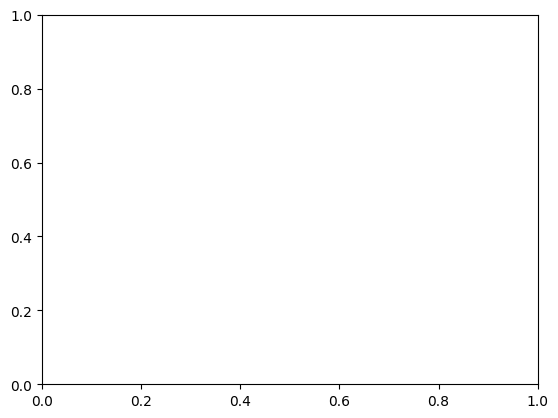

In [7]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(accuracy_for_eps), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

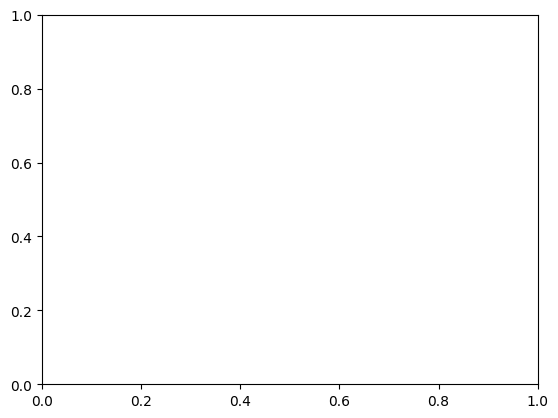

In [8]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(perturbation_for_eps), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('mean perturbation')
plt.show()

### Single sample Untargeted attack

In [10]:
epsilon = 1
eps_step = 0.005
max_iter = 5 

attack = ProjectedGradientDescentPyTorch(estimator=model, eps = epsilon, eps_step= eps_step, targeted=True, max_iter = max_iter)

In [11]:
from utils import load_image_NN1
import os
import numpy as np

target_class = 10

dataset_dir = "test_set_cropped/"
filename = "Brad_Pitt_8_face_0.jpg"
person_path = os.path.join(dataset_dir, filename)

test_img = load_image_NN1(person_path)

target_class = 10
etichetta_target = LABELS[0]
print("ETICHETTA TARGET: ", LABELS[10])

batch_size = test_img.shape[0]
print(test_img.shape[0])
targeted_labels = np.array([target_class] * batch_size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)



test_img_numpy = test_img.numpy()
test_images_adv = attack.generate(test_img_numpy, one_hot_targeted_labels)
model_predictions = model.predict(test_images_adv)



model_predictions = model.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img_numpy)))
print('Average perturbation: {:4.2f}'.format(perturbation))
#targeted_attack_loss, targeted_attack_accuracy = model.evaluate(test_images_adv, targeted_labels)
#print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy))
print("Etichetta target:{}".format(LABELS[target_class]))
predicted_label = LABELS[np.array(model_predictions.argmax())]
print("{} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))

ETICHETTA TARGET:   Aaron_Hernandez
1


Average perturbation: 0.01
Etichetta target: Aaron_Hernandez
 Aaron_Hernandez con probabilità 17.00074577331543


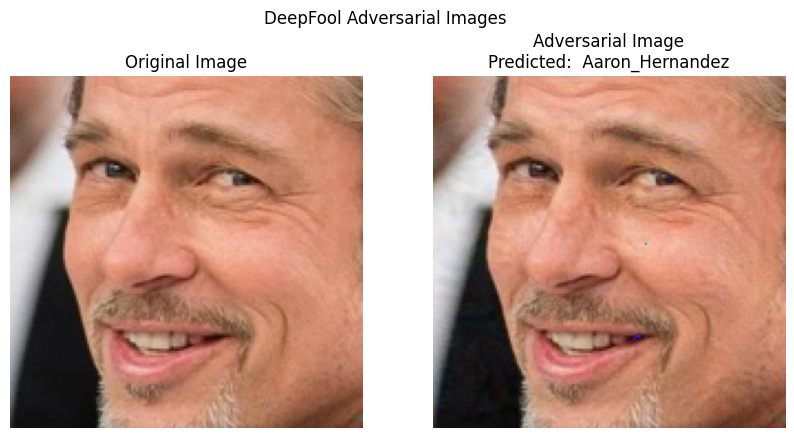

In [12]:
# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last
test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

# Converti le immagini in uint8 per la visualizzazione
if test_img_numpy.dtype != np.uint8:
    test_img_numpy = (test_img_numpy * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f'Adversarial Image\nPredicted: {predicted_label}')
ax2.axis('off')

# Mostra la figura
plt.suptitle("DeepFool Adversarial Images")
plt.show()


### Targeted Attack on all test set

In [13]:
#PGD specific Attack for all samples
import os
import re
import torch
from utils import load_image_NN1

dataset_dir = "test_set_cropped_piccolo/" 
eps_step = [2e-05, 5e-05, 7e-05, 2e-03, 5e-03, 7e-03, 2e-02, 5e-02, 7e-02, 1e-01] #La dimensione del passo della variazione dell'input a ogni iterazione. Questo parametro definisce quanto grande sarà ogni passo nella direzione del gradiente. #La dimensione del passo della variazione dell'input per il calcolo della perturbazione minima. Questo parametro è utilizzato quando minimal è impostato su True.

max_iter = [2,5,7]  # Il numero massimo di iterazioni. Questo parametro determina quante volte l'attacco iterativo sarà eseguito.

eps_range = 0.1  # Questo valore determina l'ampiezza massima della perturbazione aggiunta agli input originali. Può essere un valore singolo (int o float) o un array numpy (ndarray).

accuracy_misclassified_for_eps = []
accuracy_misclassified_for_max_iter = []
accuracy_for_eps = []
accuracy_for_max_iter = []
perturbation_for_eps = []
perturbation_for_max_iter = []
correct_misclassified = 0
total_images = 0

target_class = 10
etichetta_target = LABELS[0]
print("ETICHETTA TARGET: ", LABELS[10])
shape = 1 #shape di test image 
batch_size = shape
targeted_labels = np.array([target_class] * batch_size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)

print("Inizio Attacco PGD NON-TARGETED")
for i in range(len(max_iter)):
        print("**** Attacco con max_iter {} **** ".format(max_iter[i]))
        for step in eps_step:   #Se qualcosa funziona strano controllare questo zip
            correct_predictions = 0
            total_images = 0
            perturbation = []
            
            attack = ProjectedGradientDescentPyTorch(estimator=model, eps = eps_range, eps_step=step, targeted=True, max_iter = max_iter[i])
            
            print("**** Attacco con eps:{} con step a {} ****".format(eps_range,step))
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image_NN1(person_path)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img, one_hot_targeted_labels)
                    model_predictions = model.predict(test_images_adv)
                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                    print("Etichetta corretta:", correct_label)   
                    perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  #Salvo le perturbazioni applicate su ogni immagine
                    predicted_label = LABELS[np.array(model_predictions[0].argmax())]
                    print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    total_images+=1
                    
                    predicted_label = str(predicted_label)

                    if correct_label in predicted_label:
                        correct_predictions+=1
                        
                    if etichetta_target in predicted_label:  
                        correct_misclassified = correct_misclassified+1   #Se il modello predice l'etichetta target allora è correttamente misclassificato

                    accuracy_misclassified = correct_misclassified/total_images
                    print("Adversarial Sample misclassificati correttamente attualmente: {}%".format((accuracy_misclassified)))
                    print("Accuracy attuale: {}%".format((correct_predictions/total_images)*100))
                    print("")

            if total_images != 0:    #Per ogni epsilon impostata salvo in accuracy plot
                if len(perturbation) == total_images:
                    perturbazione_media = sum(perturbation)/total_images    #Calcolo la media delle perturbazioni applicate su tutte le immagini per una determinata epsilon
                    perturbation_for_eps.append(perturbazione_media)
                    print("----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: {} equivale a {}% ----------------".format(step,perturbazione_media))

                final_accuracy = correct_predictions/total_images
                accuracy_for_eps.append(final_accuracy)
                print("----------- Accuracy sugli adversarial Sample per eps_step: {} equivale a {}% ----------------".format(step,final_accuracy))
                
                accuracy_misclassified = correct_misclassified/total_images
                accuracy_misclassified_for_eps.append(accuracy_misclassified)
                print("----------- Adversarial Sample misclassificati correttamente: {}% -----------".format((accuracy_misclassified)))
                print("")
            #Per ogni epsilon impostata salvo in accuracy plot
        if True:#len(perturbation_for_eps) == len(eps_range):
            perturbazione_media_per_max_iter = sum(perturbation_for_eps)/len(eps_step) # Calcolo la perturbazione media dopo aver provato tutte le epsilon,quindi la media delle perturbazioni per eps_range
            perturbation_for_max_iter.append(perturbazione_media_per_max_iter)
            print("----------- Perturbazione media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],perturbation_for_max_iter[i]))
            perturbation_for_eps = []
        if True:#len(accuracy_for_eps) == len(eps_range):
            accuracy_media_per_max_iter = sum(accuracy_for_eps)/len(eps_step) # Calcolo l'accuracy media dopo aver provato tutte le epsilon,quindi la media dell'accuracy per ogni eps_range
            accuracy_for_max_iter.append(accuracy_media_per_max_iter)
            print("----------- Accuracy media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_for_max_iter[i]))
            accuracy_for_eps = []

        if True:
            accuracy__misclassified_media_per_max_iter = sum(accuracy_misclassified_for_eps)/len(eps_step) # Calcolo l'accuracy media dopo aver provato tutte le epsilon,quindi la media dell'accuracy per ogni eps_range
            accuracy_misclassified_for_max_iter.append(accuracy__misclassified_media_per_max_iter)
            print("----------- Accuracy MISCLASSIFIED media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_misclassified_for_max_iter[i]))
            accuracy_misclassified_for_eps = []
        print("")

        print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")
        print("")

# correct_predictions = 0
# total_images = 0
# target_class = 10
# print("ETICHETTA TARGET: ", LABELS[10])
# batch_size = test_img.shape[0]
# targeted_labels = np.array([target_class] * batch_size)
# one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)

# for filename in os.listdir(dataset_dir):
#     if filename.endswith(".jpg") or filename.endswith(".jpeg"):
#         person_path = os.path.join(dataset_dir, filename)
#         print("Immagine:", filename)
#         test_img = load_image(person_path)
#         test_img = test_img.unsqueeze(0)
#         test_img = test_img.numpy()
#         test_images_adv = attack.generate(test_img, one_hot_targeted_labels)
#         model_predictions = model.predict(test_images_adv)
#         correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
#         print("Etichetta corretta:", correct_label)   
#         perturbation = np.mean(np.abs((test_images_adv - test_img)))
#         predicted_label = LABELS[np.array(model_predictions[0].argmax())]
#         print("Predetto {} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))
#         total_images+=1

#         if predicted_label == correct_label:
#             correct_predictions+=1

#         accuracy = correct_predictions/total_images
#         print("Accuracy sugli adversarial Sample: {}%".format((100-(accuracy*100))))
        

# if total_images != 0:
#     final_accuracy = correct_predictions/total_images
#     print("----------- Accuracy FINALE sugli adversarial Sample: {}\% ----------------".format(final_accuracy))

ETICHETTA TARGET:   Aaron_Hernandez
Inizio Attacco PGD NON-TARGETED
**** Attacco con max_iter 2 **** 
**** Attacco con eps:0.1 con step a 2e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.70524787902832 e con perturbazione 3.815378659055568e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.500913619995117 e con perturbazione 3.808758992818184e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 11.141061782836914 e con perturbazione 3.7927784433122724e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.847076416015625 e con perturbazione 3.818137338384986e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.299497604370117 e con perturbazione 3.79367484129034e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.17966079711914 e con perturbazione 3.815024683717638e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.727594375610352 e con perturbazione 3.8000962376827374e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 12.050915718078613 e con perturbazione 3.7810525100212544e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.932771682739258 e con perturbazione 3.7942667404422536e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.546086311340332 e con perturbazione 3.705601193360053e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 2e-05 equivale a 3.792476964008529e-05% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 2e-05 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 5e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.675054550170898 e con perturbazione 9.478660649619997e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.492435455322266 e con perturbazione 9.431529906578362e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 11.093883514404297 e con perturbazione 9.376949310535565e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.772257804870605 e con perturbazione 9.419312118552625e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.262866973876953 e con perturbazione 9.387417958350852e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.139659881591797 e con perturbazione 9.419995330972597e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.687962532043457 e con perturbazione 9.380964183947071e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 12.016257286071777 e con perturbazione 9.367324673803523e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.91338062286377 e con perturbazione 9.403058356838301e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.42492961883545 e con perturbazione 9.133615822065622e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 5e-05 equivale a 9.379882831126452e-05% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 5e-05 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 7e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.65493392944336 e con perturbazione 0.00013202628178987652
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.487000465393066 e con perturbazione 0.00013156778004486114
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 11.062817573547363 e con perturbazione 0.00013037893222644925
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.722149848937988 e con perturbazione 0.00013129840954206884
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.238557815551758 e con perturbazione 0.00013086946273688227
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.112841606140137 e con perturbazione 0.0001311008381890133
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.661876678466797 e con perturbazione 0.0001309049839619547
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.993500709533691 e con perturbazione 0.00013070764543954283
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.899274826049805 e con perturbazione 0.00013128486170899123
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.344752311706543 e con perturbazione 0.0001257224939763546
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 7e-05 equivale a 0.00013058616896159946% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 7e-05 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 10.866847038269043 e con perturbazione 0.0033454580698162317
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 9.641149520874023 e con perturbazione 0.0032443483360111713
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Mai_Phương_Thúy con probabilità 8.75091552734375 e con perturbazione 0.0029610740020871162
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 9.610480308532715 e con perturbazione 0.00310289254412055
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 10.887500762939453 e con perturbazione 0.003230649745091796
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 60.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 10.772214889526367 e con perturbazione 0.003201912622898817
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 10.907182693481445 e con perturbazione 0.0032038434874266386
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 71.42857142857143%


Etichetta corretta: Christopher_Nolan
Predetto  Don_Mattingly con probabilità 9.52818489074707 e con perturbazione 0.0030858274549245834
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 62.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 11.130563735961914 e con perturbazione 0.0032270620577037334
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Diego_Maradona
Predetto  Paolo_Goltz con probabilità 10.350337982177734 e con perturbazione 0.002507593482732773
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 60.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.003111066180281341% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.6% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.005 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 9.433029174804688 e con perturbazione 0.007204160559922457
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  J._J._Watt con probabilità 9.43207836151123 e con perturbazione 0.006954031065106392
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Minzy con probabilità 7.959446430206299 e con perturbazione 0.006323562934994698
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Gloria_Hunniford con probabilità 9.565232276916504 e con perturbazione 0.0063973902724683285
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Vladimir_Petković con probabilità 9.115487098693848 e con perturbazione 0.0067723896354436874
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 8.513855934143066 e con perturbazione 0.006776426453143358
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 8.280017852783203 e con perturbazione 0.006607025396078825
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 42.857142857142854%


Etichetta corretta: Christopher_Nolan
Predetto  Don_Mattingly con probabilità 8.879210472106934 e con perturbazione 0.006560411304235458
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 37.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 11.97818374633789 e con perturbazione 0.006710411049425602
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Diego_Maradona
Predetto  Luis_Scola con probabilità 8.835240364074707 e con perturbazione 0.006033198442310095
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 30.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.005 equivale a 0.00663390071131289% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.005 equivale a 0.3% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.007 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 8.95102310180664 e con perturbazione 0.009209933690726757
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  J._J._Watt con probabilità 9.537826538085938 e con perturbazione 0.009220883250236511
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Park_Ji-yeon con probabilità 9.177790641784668 e con perturbazione 0.008367023430764675
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Gloria_Hunniford con probabilità 9.505133628845215 e con perturbazione 0.008465282618999481
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Vladimir_Petković con probabilità 8.698884010314941 e con perturbazione 0.008812004700303078
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Sergio_Goyri con probabilità 8.221293449401855 e con perturbazione 0.008859572000801563
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 16.666666666666664%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 7.9355902671813965 e con perturbazione 0.008184907957911491
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 14.285714285714285%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 9.106475830078125 e con perturbazione 0.00833128485828638
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 12.741610527038574 e con perturbazione 0.008619681000709534
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 11.11111111111111%


Etichetta corretta: Diego_Maradona
Predetto  Steed_Malbranque con probabilità 8.931604385375977 e con perturbazione 0.008335299789905548
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 10.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.007 equivale a 0.008640587329864502% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.007 equivale a 0.1% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.02 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 8.42867374420166 e con perturbazione 0.021636975929141045
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 10.124672889709473 e con perturbazione 0.020971346646547318
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Angelique_Morgan con probabilità 9.275264739990234 e con perturbazione 0.02040780335664749
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Kate_Garraway con probabilità 10.50805377960205 e con perturbazione 0.02081197127699852
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 9.799320220947266 e con perturbazione 0.020448949187994003
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 10.651318550109863 e con perturbazione 0.020760413259267807
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 10.26325798034668 e con perturbazione 0.020189061760902405
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 11.79019546508789 e con perturbazione 0.020094793289899826
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 14.561714172363281 e con perturbazione 0.01985207572579384
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 10.462220191955566 e con perturbazione 0.020426560193300247
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.02 equivale a 0.02055999506264925% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.02 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 10.799004554748535 e con perturbazione 0.048772141337394714
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 11.46602725982666 e con perturbazione 0.04816146567463875
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Bandaru_Dattatreya con probabilità 7.557628154754639 e con perturbazione 0.04937110096216202
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Carnie_Wilson con probabilità 10.667527198791504 e con perturbazione 0.04716797545552254
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 12.598617553710938 e con perturbazione 0.04891277104616165
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 11.903817176818848 e con perturbazione 0.04740104824304581
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 8.89991283416748 e con perturbazione 0.047503914684057236
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Tomasz_Adamek con probabilità 11.589859008789062 e con perturbazione 0.047675784677267075
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 14.28353500366211 e con perturbazione 0.0461822971701622
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Cain_Velasquez con probabilità 10.25066089630127 e con perturbazione 0.048876307904720306
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.05 equivale a 0.04800248071551323% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.05 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.07 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 10.13940715789795 e con perturbazione 0.048675786703825
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 11.602696418762207 e con perturbazione 0.04943881183862686
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Mulayam_Singh_Yadav con probabilità 8.408241271972656 e con perturbazione 0.04604167118668556
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Gackt con probabilità 9.12253475189209 e con perturbazione 0.046738289296627045
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 11.309030532836914 e con perturbazione 0.04764975234866142
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 11.025104522705078 e con perturbazione 0.047367192804813385
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 9.628540992736816 e con perturbazione 0.048496097326278687
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 11.853691101074219 e con perturbazione 0.04775390774011612
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 13.612066268920898 e con perturbazione 0.046759117394685745
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Cain_Velasquez con probabilità 9.93891716003418 e con perturbazione 0.047367196530103683
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.07 equivale a 0.04762878231704235% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.07 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.1 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 10.108336448669434 e con perturbazione 0.04842187836766243
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 12.582605361938477 e con perturbazione 0.04748828709125519
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Rytmus con probabilità 8.785301208496094 e con perturbazione 0.048277348279953
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Lynda_Bellingham con probabilità 9.657625198364258 e con perturbazione 0.04822787269949913
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 11.436346054077148 e con perturbazione 0.047598958015441895
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 10.122621536254883 e con perturbazione 0.04682812839746475
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 9.645949363708496 e con perturbazione 0.04663671925663948
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 12.075883865356445 e con perturbazione 0.048561204224824905
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 11.876853942871094 e con perturbazione 0.046656250953674316
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Cain_Velasquez con probabilità 8.531878471374512 e con perturbazione 0.046872399747371674
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.1 equivale a 0.04755690470337868% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.1 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

----------- Perturbazione media con iterazione 2 sugli adversarial Sample: 0.018239602678695517\% ----------------
----------- Accuracy media con iterazione 2 sugli adversarial Sample: 0.37\% ----------------
----------- Accuracy MISCLASSIFIED media con iterazione 2 sugli adversarial Sample: 0.0\% ----------------

---------------------------------------------------------------------------------------------------------------------------------------------------------

Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.675080299377441 e con perturbazione 9.471527300775051e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.492639541625977 e con perturbazione 9.438121924176812e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 11.0945405960083 e con perturbazione 9.365747246192768e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.772198677062988 e con perturbazione 9.414106898475438e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.262914657592773 e con perturbazione 9.407746256329119e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.139570236206055 e con perturbazione 9.406360186403617e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.687837600708008 e con perturbazione 9.39993406063877e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 12.016357421875 e con perturbazione 9.39683523029089e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.9132080078125 e con perturbazione 9.425396274309605e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.432524681091309 e con perturbazione 9.133169805863872e-05
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 2e-05 equivale a 9.385894518345594e-05% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 2e-05 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 5e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.600053787231445 e con perturbazione 0.00023349354160018265
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.470657348632812 e con perturbazione 0.000232102902373299
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.97703742980957 e con perturbazione 0.00022950061247684062
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.583096504211426 e con perturbazione 0.00023204604804050177
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.169544219970703 e con perturbazione 0.00023232115199789405
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.040142059326172 e con perturbazione 0.0002318437909707427
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.590188026428223 e con perturbazione 0.00023153814254328609
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.926169395446777 e con perturbazione 0.00023037666687741876
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.860973358154297 e con perturbazione 0.00023223954485729337
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.168182373046875 e con perturbazione 0.00021810720500070602
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 5e-05 equivale a 0.0002303569606738165% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 5e-05 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 7e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.551122665405273 e con perturbazione 0.000324130873195827
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.457512855529785 e con perturbazione 0.0003231066220905632
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.895007133483887 e con perturbazione 0.00031773364753462374
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.457408905029297 e con perturbazione 0.0003220038197468966
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.106278419494629 e con perturbazione 0.00032209069468081
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.975090026855469 e con perturbazione 0.00032198592089116573
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.524709701538086 e con perturbazione 0.00032188245677389205
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.860847473144531 e con perturbazione 0.0003204438544344157
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.826787948608398 e con perturbazione 0.0003219696518499404
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.014398574829102 e con perturbazione 0.00030073602101765573
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 7e-05 equivale a 0.000319608356221579% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 7e-05 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 9.371219635009766 e con perturbazione 0.007261357270181179
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  J._J._Watt con probabilità 9.372086524963379 e con perturbazione 0.006917208898812532
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Park_Ji-yeon con probabilità 8.909128189086914 e con perturbazione 0.006289359647780657
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Gloria_Hunniford con probabilità 9.212250709533691 e con perturbazione 0.006547736935317516
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Vladimir_Petković con probabilità 9.042558670043945 e con perturbazione 0.006776010151952505
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 8.543285369873047 e con perturbazione 0.006768693216145039
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 8.70347785949707 e con perturbazione 0.006558024324476719
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 42.857142857142854%


Etichetta corretta: Christopher_Nolan
Predetto  Don_Mattingly con probabilità 8.95065689086914 e con perturbazione 0.006558606401085854
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 37.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 12.957079887390137 e con perturbazione 0.006810816004872322
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Diego_Maradona
Predetto  Paolo_Goltz con probabilità 11.920894622802734 e con perturbazione 0.005303598009049892
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 30.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.006579141085967422% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.3% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.005 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 9.318333625793457 e con perturbazione 0.01440721470862627
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 12.714842796325684 e con perturbazione 0.01310304831713438
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Aaron_Hernandez con probabilità 11.266731262207031 e con perturbazione 0.01208495069295168
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 11.849750518798828 e con perturbazione 0.012869324535131454
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 12.4056396484375 e con perturbazione 0.013224402442574501
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 13.541823387145996 e con perturbazione 0.013356433250010014
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 13.93574333190918 e con perturbazione 0.013038204051554203
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 14.72474479675293 e con perturbazione 0.012052270583808422
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 16.98843002319336 e con perturbazione 0.012513205409049988
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 14.698561668395996 e con perturbazione 0.011481436900794506
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.005 equivale a 0.012813049089163541% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.005 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.007 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 12.535280227661133 e con perturbazione 0.017998864874243736
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 14.02619457244873 e con perturbazione 0.016383780166506767
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Aaron_Hernandez con probabilità 13.577463150024414 e con perturbazione 0.01593642681837082
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 13.082155227661133 e con perturbazione 0.016332920640707016
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 15.252928733825684 e con perturbazione 0.016516491770744324
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 16.704809188842773 e con perturbazione 0.016629312187433243
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 14.087674140930176 e con perturbazione 0.0159528236836195
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 15.814957618713379 e con perturbazione 0.015403203666210175
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 18.220640182495117 e con perturbazione 0.015282729640603065
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 13.792699813842773 e con perturbazione 0.01511993259191513
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.007 equivale a 0.01615564860403538% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.007 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.02 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 14.342877388000488 e con perturbazione 0.039448171854019165
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 17.91695213317871 e con perturbazione 0.038278885185718536
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Aaron_Hernandez con probabilità 13.399269104003906 e con perturbazione 0.036773160099983215
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 13.217912673950195 e con perturbazione 0.03750857710838318
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 16.19948959350586 e con perturbazione 0.0376741997897625
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 16.884241104125977 e con perturbazione 0.03730910271406174
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 15.479400634765625 e con perturbazione 0.03641796484589577
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 16.611024856567383 e con perturbazione 0.036125779151916504
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 18.48054313659668 e con perturbazione 0.03553670272231102
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 14.203195571899414 e con perturbazione 0.036945562809705734
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.02 equivale a 0.037201810628175735% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.02 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 12.973037719726562 e con perturbazione 0.06128190457820892
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 15.329715728759766 e con perturbazione 0.061636071652173996
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Aaron_Hernandez con probabilità 12.58303451538086 e con perturbazione 0.060453783720731735
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 11.888715744018555 e con perturbazione 0.061033859848976135
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 15.194878578186035 e con perturbazione 0.06071550399065018
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 15.427939414978027 e con perturbazione 0.06168684735894203
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 12.907949447631836 e con perturbazione 0.06056054309010506
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 14.013166427612305 e con perturbazione 0.0614316426217556
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 16.108407974243164 e con perturbazione 0.06091602146625519
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 11.407883644104004 e con perturbazione 0.0598125085234642
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.05 equivale a 0.0609528686851263% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.05 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.07 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 11.168891906738281 e con perturbazione 0.06498033553361893
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 12.429253578186035 e con perturbazione 0.0654175877571106
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Aaron_Hernandez con probabilità 12.180493354797363 e con perturbazione 0.06526680290699005
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Nate_Diaz con probabilità 10.423831939697266 e con perturbazione 0.06560859829187393
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 13.609719276428223 e con perturbazione 0.0644238293170929
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 10.379194259643555 e con perturbazione 0.0645342543721199
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 11.26534652709961 e con perturbazione 0.06487083435058594
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 11.353034973144531 e con perturbazione 0.0645621120929718
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 14.040642738342285 e con perturbazione 0.06465612351894379
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 10.562646865844727 e con perturbazione 0.06443697959184647
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.07 equivale a 0.06487574577331542% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.07 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.1 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Joe_Girardi con probabilità 10.666610717773438 e con perturbazione 0.06812760978937149
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 12.450239181518555 e con perturbazione 0.06993881613016129
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Imanol_Harinordoquy con probabilità 10.525252342224121 e con perturbazione 0.06803255528211594
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 10.424654960632324 e con perturbazione 0.06815366446971893
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Hans_Jörg_Schelling con probabilità 11.143529891967773 e con perturbazione 0.06630990654230118
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 11.234659194946289 e con perturbazione 0.06805990636348724
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 9.616072654724121 e con perturbazione 0.06742969155311584
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Ivan_Perišić con probabilità 10.401275634765625 e con perturbazione 0.06584896892309189
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Paul_Gallen con probabilità 11.029582977294922 e con perturbazione 0.06555990129709244
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  José_Mayer con probabilità 11.566534996032715 e con perturbazione 0.06758464872837067
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.1 equivale a 0.06750456690788269% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.1 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

----------- Perturbazione media con iterazione 5 sugli adversarial Sample: 0.026672665503574534\% ----------------
----------- Accuracy media con iterazione 5 sugli adversarial Sample: 0.3\% ----------------
----------- Accuracy MISCLASSIFIED media con iterazione 5 sugli adversarial Sample: 0.0\% ----------------

--------------------------------------------------------------------------------------------------------------------------------------------------------------

Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.655025482177734 e con perturbazione 0.00013200419198255986
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.487035751342773 e con perturbazione 0.000131381384562701
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 11.06424617767334 e con perturbazione 0.0001300091971643269
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.72201156616211 e con perturbazione 0.00013114635657984763
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.238460540771484 e con perturbazione 0.00013126460544299334
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.112828254699707 e con perturbazione 0.0001308231585426256
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.66160774230957 e con perturbazione 0.00013098487397655845
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.993555068969727 e con perturbazione 0.0001306749472860247
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.899182319641113 e con perturbazione 0.00013128985301591456
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.355018615722656 e con perturbazione 0.0001266503968508914
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 2e-05 equivale a 0.00013062289654044434% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 2e-05 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 5e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.551309585571289 e con perturbazione 0.0003236937627661973
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.457374572753906 e con perturbazione 0.00032257914426736534
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.896738052368164 e con perturbazione 0.0003174907760694623
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.457640647888184 e con perturbazione 0.0003218035853933543
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.106240272521973 e con perturbazione 0.0003220853104721755
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.97534465789795 e con perturbazione 0.0003221252700313926
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.524112701416016 e con perturbazione 0.00032116370857693255
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.860851287841797 e con perturbazione 0.0003196679172106087
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.826855659484863 e con perturbazione 0.00032128512975759804
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 11.98759651184082 e con perturbazione 0.00030251668067649007
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 5e-05 equivale a 0.00031944112852215766% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 5e-05 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 7e-05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.483259201049805 e con perturbazione 0.0004494529857765883
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.441434860229492 e con perturbazione 0.00044626538874581456
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.763509750366211 e con perturbazione 0.00043744296999648213
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.280923843383789 e con perturbazione 0.0004449677071534097
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.01657772064209 e con perturbazione 0.0004459944902919233
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.883732795715332 e con perturbazione 0.00044569020974449813
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.432852745056152 e con perturbazione 0.00044545799028128386
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.768342018127441 e con perturbazione 0.00044339700252749026
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.774932861328125 e con perturbazione 0.00044584739953279495
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 11.85106372833252 e con perturbazione 0.0004137395299039781
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 7e-05 equivale a 0.00044182556739542634% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 7e-05 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 8.529658317565918 e con perturbazione 0.009271716699004173
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 9.23924732208252 e con perturbazione 0.00871313363313675
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Minzy con probabilità 9.466490745544434 e con perturbazione 0.007938931696116924
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 9.674560546875 e con perturbazione 0.008421055041253567
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Vladimir_Petković con probabilità 8.472454071044922 e con perturbazione 0.008588546887040138
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Sergio_Goyri con probabilità 8.972684860229492 e con perturbazione 0.008596079424023628
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 16.666666666666664%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 10.350833892822266 e con perturbazione 0.008362184278666973
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 14.285714285714285%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 12.126363754272461 e con perturbazione 0.008311883546411991
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 15.29301929473877 e con perturbazione 0.008625230751931667
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 11.11111111111111%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 11.683928489685059 e con perturbazione 0.006987080443650484
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 10.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.00838158424012363% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.1% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.005 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 13.706618309020996 e con perturbazione 0.017631692811846733
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 15.310330390930176 e con perturbazione 0.015836510807275772
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Aaron_Hernandez con probabilità 13.18055534362793 e con perturbazione 0.014216587878763676
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 13.587069511413574 e con perturbazione 0.015556562691926956
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 16.434112548828125 e con perturbazione 0.015703566372394562
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 17.999601364135742 e con perturbazione 0.015949660912156105
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 16.815122604370117 e con perturbazione 0.01573585905134678
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 17.126951217651367 e con perturbazione 0.014062553644180298
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 18.924165725708008 e con perturbazione 0.014756953343749046
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 16.021425247192383 e con perturbazione 0.013426877558231354
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.005 equivale a 0.015287682507187128% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.005 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.007 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 15.520523071289062 e con perturbazione 0.021416837349534035
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 16.96971893310547 e con perturbazione 0.019467614591121674
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Aaron_Hernandez con probabilità 17.069747924804688 e con perturbazione 0.018132686614990234
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 14.943672180175781 e con perturbazione 0.019419126212596893
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 17.225130081176758 e con perturbazione 0.01880626752972603
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 18.809818267822266 e con perturbazione 0.019421115517616272
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 16.434785842895508 e con perturbazione 0.018435271456837654
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 17.078638076782227 e con perturbazione 0.01752781867980957
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 19.12345314025879 e con perturbazione 0.017479345202445984
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 16.156173706054688 e con perturbazione 0.01711384207010269
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.007 equivale a 0.018721992522478102% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.007 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.02 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 15.834602355957031 e con perturbazione 0.044233065098524094
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 18.87029457092285 e con perturbazione 0.042740870267152786
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Aaron_Hernandez con probabilità 17.794113159179688 e con perturbazione 0.0413760207593441
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 14.776573181152344 e con perturbazione 0.042159877717494965
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 17.858671188354492 e con perturbazione 0.04197784140706062
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 17.755643844604492 e con perturbazione 0.041820820420980453
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 16.831077575683594 e con perturbazione 0.041103895753622055
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 17.40737533569336 e con perturbazione 0.04074348509311676
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 19.24744987487793 e con perturbazione 0.04055936262011528
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 14.946090698242188 e con perturbazione 0.041454415768384933
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.02 equivale a 0.0418169654905796% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.02 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.05 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 14.223888397216797 e con perturbazione 0.061672527343034744
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 15.068290710449219 e con perturbazione 0.061463553458452225
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Aaron_Hernandez con probabilità 11.734959602355957 e con perturbazione 0.060128264129161835
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 12.574553489685059 e con perturbazione 0.06109701097011566
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 15.265563011169434 e con perturbazione 0.060866545885801315
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 15.537111282348633 e con perturbazione 0.060865242034196854
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 12.705669403076172 e con perturbazione 0.05979752913117409
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 14.6382474899292 e con perturbazione 0.06094922497868538
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 15.68222713470459 e con perturbazione 0.06087760999798775
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 14.149371147155762 e con perturbazione 0.06047005206346512
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.05 equivale a 0.0608187559992075% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.05 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.07 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 13.450439453125 e con perturbazione 0.06611549854278564
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 13.861428260803223 e con perturbazione 0.0657673180103302
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  Aaron_Hernandez con probabilità 10.138200759887695 e con perturbazione 0.06531159579753876
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 12.42045783996582 e con perturbazione 0.06555768847465515
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 14.674254417419434 e con perturbazione 0.06476837396621704
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 11.53678035736084 e con perturbazione 0.06509778648614883
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 12.456421852111816 e con perturbazione 0.06402578949928284
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 11.717397689819336 e con perturbazione 0.06379114091396332
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 12.82254409790039 e con perturbazione 0.0645846351981163
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 9.865580558776855 e con perturbazione 0.06433021277189255
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.07 equivale a 0.06493500396609306% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.07 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

**** Attacco con eps:0.1 con step a 0.1 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Aaron_Hernandez con probabilità 10.175239562988281 e con perturbazione 0.06605209410190582
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 13.814019203186035 e con perturbazione 0.0676666796207428
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ariana_Grande
Predetto  James_Haskell con probabilità 12.76019287109375 e con perturbazione 0.06630079448223114
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 13.81332015991211 e con perturbazione 0.0669531375169754
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Boris_Johnson
Predetto  Aaron_Hernandez con probabilità 11.450824737548828 e con perturbazione 0.06602214276790619
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Brad_Pitt
Predetto  Aaron_Hernandez con probabilità 11.143688201904297 e con perturbazione 0.06591146439313889
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 10.112695693969727 e con perturbazione 0.06444922834634781
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 10.59168815612793 e con perturbazione 0.06675522029399872
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 10.92946720123291 e con perturbazione 0.06378516554832458
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%


Etichetta corretta: Diego_Maradona
Predetto  Aaron_Hernandez con probabilità 10.124704360961914 e con perturbazione 0.06436588615179062
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 0.0%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.1 equivale a 0.0658261813223362% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.1 equivale a 0.0% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------

----------- Perturbazione media con iterazione 7 sugli adversarial Sample: 0.027668005564046326\% ----------------
----------- Accuracy media con iterazione 7 sugli adversarial Sample: 0.28\% ----------------
----------- Accuracy MISCLASSIFIED media con iterazione 7 sugli adversarial Sample: 0.0\% ----------------

---------------------------------------------------------------------------------------------------------------------------------------------------------

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

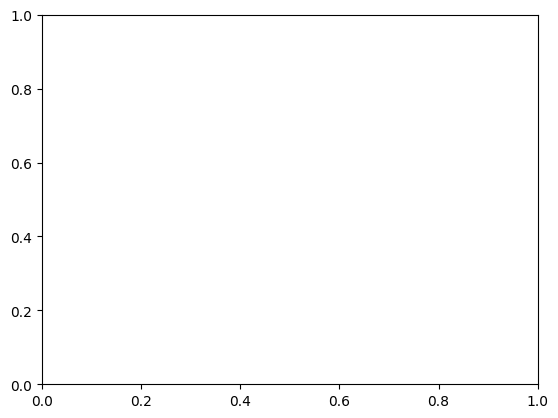

In [14]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(accuracy_for_eps), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(perturbation_for_eps), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('mean perturbation')
plt.show()

### Single sample Targeted attack

In [15]:
epsilon = 1
eps_step = 0.005
max_iter = 5 

attack = ProjectedGradientDescentPyTorch(estimator=model, eps = epsilon, eps_step= eps_step, targeted=True, max_iter = max_iter)

In [16]:
from utils import load_image_NN1
import os
import numpy as np

target_class = 10

dataset_dir = "test_set_cropped/"
filename = "Brad_Pitt_8_face_0.jpg"
person_path = os.path.join(dataset_dir, filename)

test_img = load_image_NN1(person_path)
target_class = 10
etichetta_target = LABELS[0]
print("ETICHETTA TARGET: ", LABELS[10])
batch_size = test_img.shape[0]
targeted_labels = np.array([target_class] * batch_size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)
print(one_hot_targeted_labels.shape)


test_img_numpy = test_img.numpy()
test_images_adv = attack.generate(test_img_numpy, one_hot_targeted_labels)
model_predictions = model.predict(test_images_adv)



model_predictions = model.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img_numpy)))
print('Average perturbation: {:4.2f}'.format(perturbation))
#targeted_attack_loss, targeted_attack_accuracy = model.evaluate(test_images_adv, targeted_labels)
#print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy))
print("Etichetta target:{}".format(LABELS[target_class]))
predicted_label = LABELS[np.array(model_predictions.argmax())]
print("{} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))

ETICHETTA TARGET:   Aaron_Hernandez
(1, 8631)


Average perturbation: 0.01
Etichetta target: Aaron_Hernandez
 Aaron_Hernandez con probabilità 17.00074577331543


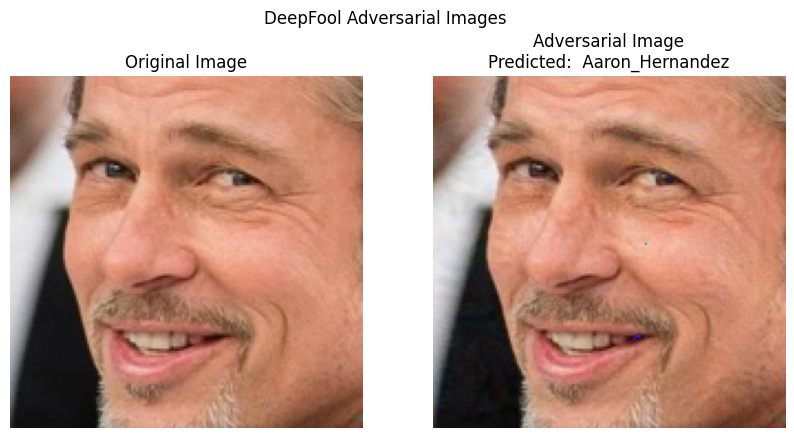

In [17]:
# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last
test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

# Converti le immagini in uint8 per la visualizzazione
if test_img_numpy.dtype != np.uint8:
    test_img_numpy = (test_img_numpy * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f'Adversarial Image\nPredicted: {predicted_label}')
ax2.axis('off')

# Mostra la figura
plt.suptitle("DeepFool Adversarial Images")
plt.show()